# Reconocimiento de imágenes con TensorFlow. REDES NEURONALES CONVOLUCIONALES (CNN)

In [71]:
#!pip install --upgrade pip
#!pip install pandas 
#!pip install tqdm 
#!pip install scikit-learn 
#!pip install scikit-image
#!pip install imblearn
#!pip install import-ipynb

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm #barra de progreso
import cv2

#para redimensionar
import sklearn
import skimage
from skimage.transform import resize

import random

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

#para cargar imágenes desde internet usaremos estas librerías
from PIL import Image
import requests
from io import BytesIO

## Funciones

In [72]:
# Preprocesado: redimensionado 150x150, escala de grises (eliminar capa de color) y conversión a array
def preprocess(image):
    image = skimage.transform.resize(image, (150,150,3), mode = 'constant', anti_aliasing=True)
    image = rgb2gray(image)
    image_array = np.asarray(image)
    return image_array

In [73]:
# Carga de datos
def get_images(dir): #dir = chest_xray/train/ o chest_xray/test/
    IMAGES = []
    LABELS = []
    
    for subdir in os.listdir(dir): #lista de subdirectorios en train/ o test/ -> ['NORMAL', 'PNEUMONIA']
        if not subdir.startswith('.'):
            if subdir in ['NORMAL']:
                label = 0
            elif subdir in ['PNEUMONIA']:
                label = 1
            else: 
                label = 2
                    
            for image_name in tqdm(os.listdir(dir+subdir)): #barra de progreso
                image = cv2.imread(dir + subdir + '/' + image_name) #lectura
                if image is not None:
                    #bloque de preprocesado
                    image_array = preprocess(image)    
                                 
                    #add a listas de arrays y de labels
                    IMAGES.append(image_array) 
                    LABELS.append(label) 
        
    IMAGES = np.asarray(IMAGES)
    LABELS = np.asarray(LABELS)
    return IMAGES, LABELS

In [74]:
LOADED = True
if LOADED == False:
    x_train, y_train = get_images("chest_xray/train/") #nº de imgs normal = nº imgs pneu
    x_test, y_test = get_images("chest_xray/test/") #no dimensionados
    
    #almacenamiento de arrays en archivos
    np.save('xtrain.npy', x_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', x_test)
    np.save('ytest.npy', y_test)            
    
else:
    x_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    x_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')

In [75]:
x_train = x_train.reshape(len(x_train),150,150,1)
x_test = x_test.reshape(len(x_test),150,150,1)

## Definición del modelo de CNN

In [76]:
model = models.Sequential()

# 1) Se crea un mapa o array de valores más pequeño que caracteriza a la imagen
#    64 filtros, tamaño 3x3, función de activación rectificadora (relu)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))

# 2) Se aplica un filtro MAX (obtiene el valor máximo de cada sección de píxeles) para obtener una capa de reducción o imagen más pequeña
#    Ventana que recorre el mapa de características, máximo de valores, 2x2
model.add(layers.MaxPooling2D((2, 2)))



#capas internas
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))



# 3) Flatening: se deja como una capa plana de una dimensión con todos los valores
#    64 valores a la entrada, 2 neuronas a la salida [NORMAL, PNEUMONIA]
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu')) #capa densa, función de activación rectificadora (relu)
model.add(layers.Dense(2, activation='softmax')) #capa densa, función de activación softmax siempre a la salida



model.summary() #resumen de la estructura de la red neuronal
#los parámetros son los pesos

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

In [77]:
#se compila el modelo
model.compile(
    optimizer = 'adam', #se optimiza con el método de adam que es mejor que el gradiente descendente
    loss = 'sparse_categorical_crossentropy', #función de pérdidas, probabilidad de que una prenda pertenezca a una clase
    metrics = ['accuracy']
)

In [78]:
model.fit(x_train, y_train, epochs=10) #una época equivale a un procesamiento completo de todas las imágenes del dataset

#SEGUNDA VERSIÓN -> TENSORBOARD: depuración y checkeo de progreso del modelo con logs e histogramas
""" 
cp_callbacks = tf.keras.callbacks.ModelCheckpoint("checkpoints/", save_weights_only=True, verbose=1) #se van guardando los pesos de cada época
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1) #directorio de log con la fecha

model.fit(
    x_train,
    y_train, 
    epochs=3,
    validation_data = (test_images,test_labels),
    callbacks = [cp_callbacks, tensorboard_callback]
) 
"""

#EN TERMINAL -> tensorboard --logdir logs/ #visualización del tensorboard

Epoch 1/10
84/84 [==============================] - 67s 789ms/step - loss: 0.3972 - accuracy: 0.8173
Epoch 2/10
84/84 [==============================] - 66s 789ms/step - loss: 0.1717 - accuracy: 0.9310
Epoch 3/10
84/84 [==============================] - 67s 793ms/step - loss: 0.1268 - accuracy: 0.9545
Epoch 4/10
84/84 [==============================] - 67s 792ms/step - loss: 0.1139 - accuracy: 0.9594
Epoch 5/10
84/84 [==============================] - 67s 796ms/step - loss: 0.0929 - accuracy: 0.9705
Epoch 6/10
84/84 [==============================] - 68s 805ms/step - loss: 0.0651 - accuracy: 0.9773
Epoch 7/10
84/84 [==============================] - 69s 821ms/step - loss: 0.0525 - accuracy: 0.9787
Epoch 8/10
84/84 [==============================] - 69s 825ms/step - loss: 0.0665 - accuracy: 0.9754
Epoch 9/10
84/84 [==============================] - 70s 833ms/step - loss: 0.0509 - accuracy: 0.9799
Epoch 10/10
84/84 [==============================] - 72s 857ms/step - loss: 0.0359 - accura

' \ncp_callbacks = tf.keras.callbacks.ModelCheckpoint("checkpoints/", save_weights_only=True, verbose=1) #se van guardando los pesos de cada época\ntensorboard_callback = tf.keras.callbacks.TensorBoard("logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1) #directorio de log con la fecha\n\nmodel.fit(\n    x_train,\n    y_train, \n    epochs=3,\n    validation_data = (test_images,test_labels),\n    callbacks = [cp_callbacks, tensorboard_callback]\n) \n'

In [79]:
#se obtienen las pérdidas y la precisión del modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test)
#si la precisión obtenida aquí es mucho menor que la de las épocas, se está sobreentrenando el modelo

20/20 [==============================] - 4s 195ms/step - loss: 0.8673 - accuracy: 0.7885


## Prueba predicción imagen externa

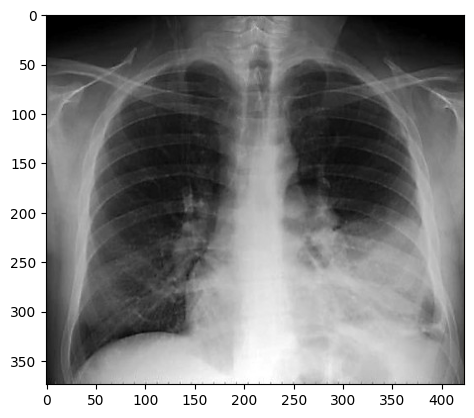

(664, 1152)

In [101]:
#se obtiene una imagen de internet
#response = requests.get("https://www.scielo.cl/fbpe/img/rchradiol/v10n4/pag173fig2.jpg")
#image_ext = Image.open(BytesIO(response.content))

#se obtienen ejemplos del directorio val
image_ext = Image.open('chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg','r') 
np_image_ext = np.array(image_ext) #se convierte en numpy array

plt.figure()
plt.imshow(np_image)
plt.grid(False)
plt.show()

np_image_ext.shape

In [102]:
np_image_ext = preprocess(np_image_ext)
np_image_ext.shape

(150, 150)

In [103]:
#al modelo hay que pasarle un array de imágenes, como solo se le va a pasar una, se crea el array y se añade la imagen al mismo
array = np.zeros((1,150,150))
array[0] = np_image_ext

prediction_image = model.predict(array) #se hace la predicción
prediction_image

1/1 [==============================] - 0s 52ms/step


array([[0.00900066, 0.99099934]], dtype=float32)

In [104]:
#se indica dónde se encuentra la mayor probabilidad
if (np.argmax(prediction_image[0]) == 0):
    print("SANO")
else:
    print("NEUMONIA")


NEUMONIA
